In this example we setup and evaluate a scoring function based on XL-MS data.

In [1]:
from __future__ import print_function

import IMP
import IMP.pmi
import IMP.pmi.topology
import IMP.pmi.io
import IMP.pmi.io.crosslink
import IMP.pmi.restraints
import IMP.pmi.restraints.crosslinking

m = IMP.Model()

First we create the representation using PMI. We create two proteins:

 - ProtA with one bead, which coarse grains residues 1 to 10
 - ProtB with three beads, which coarse grains residues 1 to 10, 11 to 20 and 21 to 30.

In [2]:
s = IMP.pmi.topology.System(m)
 
st1 = s.create_state()
protA = st1.create_molecule("ProtA", "G" * 10, "A")
protA.add_representation(resolutions=[10])
protB = st1.create_molecule("ProtB", "G" * 30, "B")
protB.add_representation(resolutions=[10])
hier = s.build()

done building "ProtA" Chain A Copy: 0
done building "ProtB" Chain B Copy: 0


To make it easier to see what's going on, we'll place the beads at fixed points in space:

In [3]:
beads = IMP.atom.Selection(hier).get_selected_particles()
print(beads)
xyzs = [IMP.core.XYZ(b) for b in beads if IMP.core.XYZ.get_is_setup(b)]
xyzs[0].set_coordinates((0,0,0))
xyzs[1].set_coordinates((-40,0,0))
xyzs[2].set_coordinates((0,0,0))
xyzs[3].set_coordinates((40,0,0))

["1-10_bead", "1-10_bead", "11-20_bead", "21-30_bead"]


Next, we'll make some cross-links. The cross-link dataset is a comma separated value (CSV) file with at least the protein and the residue names (no spaces between commas):

In [4]:
xldb='''Protein 1,Protein 2,Residue 1,Residue 2,UniqueID,Score
ProtA,ProtB,1,10,1,1.0
ProtA,ProtB,1,11,2,2.0
ProtA,ProtB,1,21,3,2.0
'''
with open('xlinks.csv', 'w') as fh:
    fh.write(xldb)

Now we create a conversion map between internal keywords of cross-links features and the one in the file:

In [5]:
cldbkc = IMP.pmi.io.crosslink.CrossLinkDataBaseKeywordsConverter()
cldbkc.set_protein1_key("Protein 1")
cldbkc.set_protein2_key("Protein 2")
cldbkc.set_residue1_key("Residue 1")
cldbkc.set_residue2_key("Residue 2")

# the unique_id_key and id_score_key are optional,
# and they add features that will be explained below

cldbkc.set_unique_id_key("UniqueID")
cldbkc.set_id_score_key("Score")

With this keyword interpreter, let's read the cross-link database:

In [6]:
cldb = IMP.pmi.io.crosslink.CrossLinkDataBase(cldbkc)
cldb.create_set_from_file("xlinks.csv")

Let's check that the database looks ok:

In [7]:
print(cldb)

1
--- XLUniqueID 1
--- XLUniqueSubIndex 1
--- XLUniqueSubID 1.1
--- Protein1 ProtA
--- Protein2 ProtB
--- Residue1 1
--- Residue2 10
--- IDScore 1.0
--- Redundancy 1
--- RedundancyList ['1.1']
--- Ambiguity 1
--- Residue1LinksNumber 3
--- Residue2LinksNumber 1
-------------
2
--- XLUniqueID 2
--- XLUniqueSubIndex 1
--- XLUniqueSubID 2.1
--- Protein1 ProtA
--- Protein2 ProtB
--- Residue1 1
--- Residue2 11
--- IDScore 2.0
--- Redundancy 1
--- RedundancyList ['2.1']
--- Ambiguity 1
--- Residue1LinksNumber 3
--- Residue2LinksNumber 1
-------------
3
--- XLUniqueID 3
--- XLUniqueSubIndex 1
--- XLUniqueSubID 3.1
--- Protein1 ProtA
--- Protein2 ProtB
--- Residue1 1
--- Residue2 21
--- IDScore 2.0
--- Redundancy 1
--- RedundancyList ['3.1']
--- Ambiguity 1
--- Residue1LinksNumber 3
--- Residue2LinksNumber 1
-------------



With the database we can now set up the scoring function. Note the text generated. The program reports the nuisance particles associated to the cross-link (sigma and psi):

In [8]:
xl = IMP.pmi.restraints.crosslinking.CrossLinkingMassSpectrometryRestraint(
    root_hier=hier, CrossLinkDataBase=cldb, length=21.0, slope=0.0,
    resolution=1.0, label="XL")

gathering copies
defaultdict(<class 'int'>, {'ProtA': 0, 'ProtB': 0})
done pmi2 prelims
generating a new crosslink restraint
--------------
CrossLinkingMassSpectrometryRestraint: generating cross-link restraint between
CrossLinkingMassSpectrometryRestraint: residue 1 of chain ProtA and residue 10 of chain ProtB
CrossLinkingMassSpectrometryRestraint: with sigma1 SIGMA sigma2 SIGMA psi PSI
CrossLinkingMassSpectrometryRestraint: between particles 1-10_bead and 1-10_bead

generating a new crosslink restraint
--------------
CrossLinkingMassSpectrometryRestraint: generating cross-link restraint between
CrossLinkingMassSpectrometryRestraint: residue 1 of chain ProtA and residue 11 of chain ProtB
CrossLinkingMassSpectrometryRestraint: with sigma1 SIGMA sigma2 SIGMA psi PSI
CrossLinkingMassSpectrometryRestraint: between particles 1-10_bead and 11-20_bead

generating a new crosslink restraint
--------------
CrossLinkingMassSpectrometryRestraint: generating cross-link restraint between
CrossLinki

We can evaluate this restraint at the current system configuration:

In [9]:
print(xl.rs.unprotected_evaluate(None))

3.0602707946915624


Let's plot the score while moving ProtA bead wrt ProtB. First, we get the particle corresponding to ProtA:

In [10]:
sel = IMP.atom.Selection(hier, molecule="ProtA")
pA, = sel.get_selected_particles()

Now we can move ProtA on the x-axis:

In [11]:
scores = []
xs = []
for i in range(-100, 100):
    xs.append(float(i))
    IMP.core.XYZ(pA).set_coordinates((i, 0, 0))
    scores.append(xl.rs.unprotected_evaluate(None))

We can make a simple plot of the scores against the x coordinate. This plot shows that the system has two minima:
 - one when ProtA is between ProtB:1-10 and ProtB:11-20;
 - and the other when ProtA is between ProtB:11-20 and ProtB:21-30

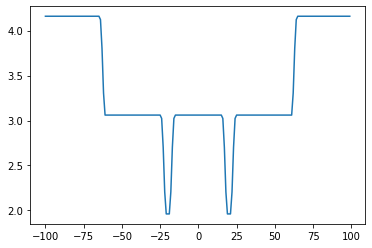

In [12]:
%matplotlib inline
import pylab

pylab.plot(xs, scores)

The plot is weird, so let's analyse what is going on.

First let's simplify our dataset, by considering only the first cross-link. Let's filter by the UniqueID, creating a new database that contains only the second cross-link, namely UniqueID=2:

In [13]:
from IMP.pmi.io.crosslink import FilterOperator
import operator

fo = FilterOperator(cldb.unique_id_key, operator.eq, "2")
fcldb = cldb.filter(fo)

print(fcldb)

2
--- DataSetName XL
--- XLUniqueID 2
--- XLUniqueSubIndex 1
--- XLUniqueSubID 2.1
--- Protein1 ProtA
--- Protein2 ProtB
--- Residue1 1
--- Residue2 11
--- IDScore 2.0
--- Redundancy 1
--- RedundancyList ['2.1']
--- State 0
--- Sigma1 SIGMA
--- Sigma2 SIGMA
--- Psi PSI
--- Ambiguity 1
--- Residue1LinksNumber 1
--- Residue2LinksNumber 1
--- Particle1 "1-10_bead" Fragment: [1, 11)  (99 0 0: 5.9919)
--- Particle2 "11-20_bead" Fragment: [11, 21)  (0 0 0: 5.9919)
--- Particle_sigma1 1e-07 <  Scale = 2 < 1000
--- Particle_sigma2 1e-07 <  Scale = 2 < 1000
--- Particle_psi 1e-07 <  Scale = 0.25 < 0.5
--- Restraint "|XL|2.1|ProtA|1|ProtB|11|0|PSI|"
--- IntraRigidBody False
--- ShortLabel |XL|2.1|ProtA|1|ProtB|11|0|PSI|
-------------



Now we can create a new restraint based on this database and, as before, score while moving ProtA:

In [14]:
xl1 = IMP.pmi.restraints.crosslinking.CrossLinkingMassSpectrometryRestraint(
    root_hier=hier, CrossLinkDataBase=fcldb, length=21.0, slope=0.0,
    resolution=1.0, label="XL")

scores=[]
xs=[]
for i in range(-100, 100):
    xs.append(float(i))
    IMP.core.XYZ(pA).set_coordinates((i, 0, 0))
    scores.append(xl1.rs.unprotected_evaluate(None))

gathering copies
defaultdict(<class 'int'>, {'ProtA': 0, 'ProtB': 0})
done pmi2 prelims
generating a new crosslink restraint
--------------
CrossLinkingMassSpectrometryRestraint: generating cross-link restraint between
CrossLinkingMassSpectrometryRestraint: residue 1 of chain ProtA and residue 11 of chain ProtB
CrossLinkingMassSpectrometryRestraint: with sigma1 SIGMA sigma2 SIGMA psi PSI
CrossLinkingMassSpectrometryRestraint: between particles 1-10_bead and 11-20_bead



It is clear that the restraint has a minimum when ProtA and ProtB:11-20 are close (namely when ProtA x is around 0). In fact, the restraint has a sigmoid shape:

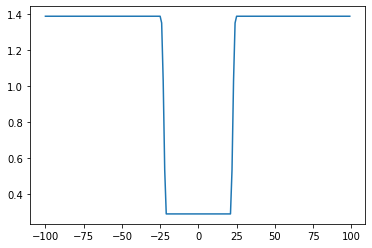

In [15]:
pylab.plot(xs, scores)

Now let's play with the parameters sigma and psi to understand their roles. Let's get sigma first:

In [16]:
sigma = xl1.sigma_dictionary["SIGMA"][0]

and let's vary its value between 1 and 20 to see what happens:

In [17]:
scores_list = []
xs_list = []
for s in range(1, 20):
    scores = []
    xs = []
    sigma.set_scale(float(s))
    for i in range(-100, 100):
        xs.append(float(i))
        IMP.core.XYZ(pA).set_coordinates((i, 0, 0))
        scores.append(xl1.rs.unprotected_evaluate(None))
    scores_list.append(scores)
    xs_list.append(xs)

From the plot, one can see sigma modulates both the slope of the sigmoid and the plateau of the minimum. This is because sigma is the structural uncertainty associated with the position of the cross-linked beads:

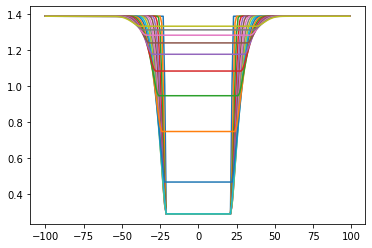

In [18]:
for xs, scores in zip(xs_list, scores_list):
    pylab.plot(xs, scores)

Let's get psi now (setting sigma back to 11), and vary its value between 0.01 and 0.5 to see what happens:

In [19]:
sigma.set_scale(11)
psi = xl1.psi_dictionary["PSI"][0]

import numpy as np

scores_list = []
xs_list = []
for s in np.linspace(0.01, 0.5, 10):
    scores = []
    xs = []
    psi.set_scale(float(s))
    for i in range(-100, 100):
        xs.append(float(i))
        IMP.core.XYZ(pA).set_coordinates((i, 0, 0))
        scores.append(xl1.rs.unprotected_evaluate(None))
    scores_list.append(scores)
    xs_list.append(xs)

Plotting the values again, one can see psi modulates the plateau of the minimum and the maxima.
This is because psi is the uncertainty associated with the crosslink observation:

 - When psi is 0.01, (low uncertainty) there is a big score difference between a satisfied cross-link (x=0) and a violated one (x=100, x=-100)
 - When psi is 0.5, (high uncertainty) the score is flat, and there is no difference between violated and satisfied cross-links

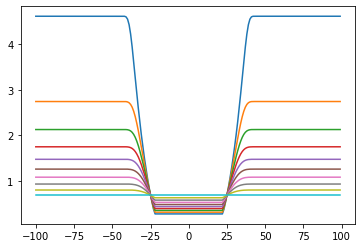

In [20]:
for xs, scores in zip(xs_list, scores_list):
    pylab.plot(xs, scores)

Now let's move the parameters when we consider all three cross-links. First, sigma:

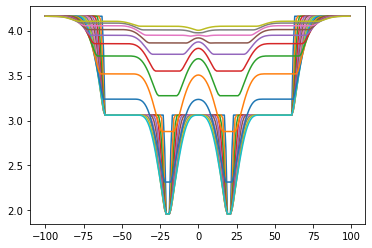

In [21]:
sigma = xl.sigma_dictionary["SIGMA"][0]

scores_list = []
xs_list = []
for s in range(1, 20):
    scores = []
    xs = []
    sigma.set_scale(float(s))
    for i in range(-100, 100):
        xs.append(float(i))
        IMP.core.XYZ(pA).set_coordinates((i, 0, 0))
        scores.append(xl.rs.unprotected_evaluate(None))
    scores_list.append(scores)
    xs_list.append(xs)

for xs, scores in zip(xs_list, scores_list):
    pylab.plot(xs, scores)

Then, for psi:

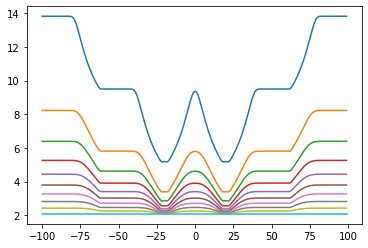

In [22]:
sigma.set_scale(11)
psi = xl.psi_dictionary["PSI"][0]

import numpy as np

scores_list = []
xs_list = []
for s in np.linspace(0.01, 0.5, 10):
    scores = []
    xs = []
    psi.set_scale(float(s))
    for i in range(-100, 100):
        xs.append(float(i))
        IMP.core.XYZ(pA).set_coordinates((i, 0, 0))
        scores.append(xl.rs.unprotected_evaluate(None))
    scores_list.append(scores)
    xs_list.append(xs)

for xs, scores in zip(xs_list, scores_list):
    pylab.plot(xs, scores)

Now we can try to optimize the values of PSI and SIGMA, and see what is the best scoring value, fixing the coordinate of ProtA to a minimum:

In [23]:
import math
import numpy as np

sel = IMP.atom.Selection(hier, molecule="ProtB")
pB1, pB2, pB3 = sel.get_selected_particles()

IMP.core.XYZ(pA).set_coordinates((0,0,0))
IMP.core.XYZ(pB1).set_coordinates((0,20,0))
IMP.core.XYZ(pB2).set_coordinates((-20*math.sqrt(3)/2,-20/2,0))
IMP.core.XYZ(pB3).set_coordinates((20*math.sqrt(3)/2,-20/2,0))

scores = []
psis = []
sigmas = []
for p in np.linspace(0.01, 0.5, 100):
    psi.set_scale(p)
    for s in np.linspace(1, 40, 50):
        psis.append(p)
        sigmas.append(s)
        sigma.set_scale(s)
        scores.append(xl.rs.unprotected_evaluate(None))

There is a minimum when PSI is close to zero and sigma is between 0 and 10:

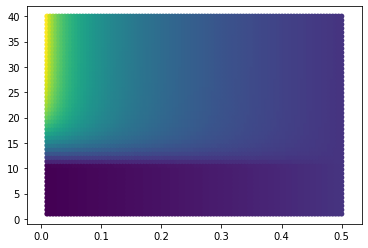

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.scatter(psis, sigmas, c=scores, s=30, edgecolor='')
plt.show()

Let's move ProtA away, so that any cross-link is satisfied:

In [25]:
IMP.core.XYZ(pA).set_coordinates((100, 100, 100))
scores = []
psis = []
sigmas = []
for p in np.linspace(0.01, 0.5, 100):
    psi.set_scale(p)
    for s in np.linspace(1, 40, 50):
        psis.append(p)
        sigmas.append(s)
        sigma.set_scale(s)
        scores.append(xl.rs.unprotected_evaluate(None))

The minimum is at Psi=0.5, irrespective of the value of Sigma:

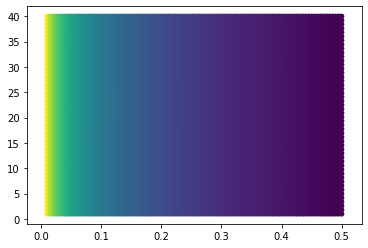

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.scatter(psis, sigmas, c=scores, s=30, edgecolor='')
plt.show()